In [1]:
import numpy as np
import pandas as pd

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/douban/comment.json
/kaggle/input/douban/movie.json
/kaggle/input/english-and-chinese-stopwords/baidu_stopwords.txt
/kaggle/input/english-and-chinese-stopwords/stopwords.txt
/kaggle/input/english-and-chinese-stopwords/scu_stopwords.txt
/kaggle/input/english-and-chinese-stopwords/hit_stopwords.txt
/kaggle/input/english-and-chinese-stopwords/cn_stopwords.txt


In [2]:
# read files
comment_file_path = "../input/douban/comment.json"
movie_file_path = "../input/douban/movie.json"

comment_data = pd.read_json(comment_file_path)
movie_data = pd.read_json(movie_file_path)

In [3]:
# remove any rows that contains nan value
def remove_nan_row(data):
    data.dropna(axis="rows", how='any', inplace=True)

remove_nan_row(comment_data)
remove_nan_row(movie_data)

comment_data[:10]

      movie     username                                            comment  \
0  泰坦尼克号 短评           沉歌                           爱你原本只是一瞬，却不知在时间的洪流中成了永恒。   
1  泰坦尼克号 短评           个篱  那对对死无所畏惧的老夫妇，那个不为外界干扰的乐队，那个为生而做一次假父亲的男人，那个为爱人吹...   
2  泰坦尼克号 短评           影志         “我甚至连一张他的画像都没有，但他永远活在我心中。” 要敢说，这是我一直深爱的电影。   
3  泰坦尼克号 短评         深海的心  若干年后，2010年12月27日凌晨一点半，我不知道还有谁醒着没睡，还有谁和我一样，刚重温过...   
4  泰坦尼克号 短评  Doublebitch                       将永远是我在电影院所看过次数最多、最感动、也是最好的电影   
5  泰坦尼克号 短评          孔雀鱼  学校组织放映的影片，大家好像对rose和jack恋爱过程猎奇，但是让我感动的一幕是轮船将要沉...   
6  泰坦尼克号 短评       大时代.歌姬                                生死两茫茫\r\n不思量\r\n自难忘   
7  泰坦尼克号 短评           眠去                                              还是会哭。   
8  泰坦尼克号 短评         峰峰峰峰  当老年的Rose午夜梦回，一个长镜头穿过大堂，摇上楼梯，站在钟表前的Jack转过身来，意气风...   
9  泰坦尼克号 短评          芦哲峰                         1998年，哈尔滨火车站地下给初恋女友买的盗版光盘。   

  score                 time     vote  
0    推荐  2007-10-14 15:40:11   9622.0  
1    力荐  2006-11-16 15:23:40  12171.0  
2    力荐  2

In [4]:
comment_data.value_counts(subset=["score"])

score
力荐       98509
推荐       57513
还行       16549
较差        2890
很差        1136
dtype: int64

In [5]:
# get star
#   >= 4 is postive
#   <= 2 is negetive
def polarity(row):
    score = row["score"]
    if score in ["力荐", "推荐"]:
        return "1" # postive
    elif score in ["较差", "很差"]:
        return "0" # negative

    
comment_data["star"] = comment_data.apply(polarity, axis=1)
comment_data.dropna(inplace=True)

count = comment_data.value_counts("star")
count

star
1    156022
0      4026
dtype: int64

In [6]:

postive_count, negative_count = count[0], count[1]

import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt  
labels=['postive','negative']
X=[postive_count, negative_count]  

fig = plt.figure()
plt.pie(X,labels=labels,autopct='%1.2f%%')

# plt.show()  
plt.savefig("pie.pdf")

plt.close()

plt.bar(labels, X)
plt.text(0, X[0], X[0], ha="center", va="bottom")
plt.text(1, X[1], X[1], ha="center", va="bottom")

plt.savefig("bar.pdf")
plt.close()

In [7]:
comment_data = comment_data.groupby("star").sample(n=10000, replace=True)

count = comment_data.value_counts("star")
count

star
0    10000
1    10000
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

comments = comment_data["comment"]
star = comment_data["star"]

# split train and test dataset
x_train, x_test, y_train, y_test, = train_test_split(
    comments.values, star.values, test_size=0.2, random_state=0)

len(y_train), len(y_test), len(x_train), len(x_test)


(16000, 4000, 16000, 4000)

In [9]:
# clean numbers and punctuations
import re
import string
import jieba
from tqdm.notebook import tqdm


# clean non-chinese characters
def clean_str(line):
    line.strip('\n')
    line = re.sub(r"[^\u4e00-\u9fff]", "", line)
    line = re.sub(
        "[0-9a-zA-Z\-\s+\.\!\/_,$%^*\(\)\+(+\"\')]+|[+——！，。？、~@#￥%……&*（）<>\[\]:：★◆【】《》;；=?？]+", "", line)
    return line.strip()


# load stop words
with open('../input/english-and-chinese-stopwords/cn_stopwords.txt') as f:
    stopwords = [line.strip('\n') for line in f.readlines()]


def cut(data, labels, stopwords):
    result = []
    new_labels = []
    for index in tqdm(range(len(data))):
        comment = clean_str(data[index])
        label = labels[index]
        # get segmentation
        seg_list = jieba.cut(comment, cut_all=False, HMM=True)
        seg_list = [x.strip('\n')
                    for x in seg_list if x not in stopwords and len(x) > 1]
        if len(seg_list) > 1:
            result.append(seg_list)
            new_labels.append(label)
    return result, new_labels

# load train & test dataset's cutting result
train_cut_result, train_labels = cut(x_train, y_train, stopwords)
test_cut_result, test_labels = cut(x_test, y_test, stopwords)

  0%|          | 0/16000 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.203 seconds.
Prefix dict has been built successfully.


  0%|          | 0/4000 [00:00<?, ?it/s]

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer: input data
train_data = [' '.join(x) for x in train_cut_result]
test_data = [' '.join(x) for x in test_cut_result]

n_dim = 20000

# calculate the TF-IDF
# when sublinear_tf=True, we can get another 1% or 2% accuracy increament
vectorizer = TfidfVectorizer(
    max_features=n_dim, smooth_idf=True, sublinear_tf=True)

# training
train_vec_data = vectorizer.fit_transform(train_data)

# transforming
test_vec_data = vectorizer.transform(test_data)

vectorizer.get_feature_names_out()[:10]

array(['一一', '一一对应', '一丁点儿', '一下', '一下子', '一不小心', '一世', '一丝', '一丝丝',
       '一两个'], dtype=object)

In [11]:
# const initial variables
n_categories = 2
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
epochs = 10
batch_size = 100

In [12]:
class TxtDataset(Dataset):
    def __init__(self, VectData, labels):
        self.VectData = VectData
        self.labels = labels

    def __getitem__(self, index):
        return self.VectData[index].toarray(), int(self.labels[index])

    def __len__(self):
        return len(self.labels)

train_dataset = TxtDataset(train_vec_data, train_labels)
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=1
                              )
test_dataset = TxtDataset(test_vec_data, test_labels)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=1
                             )

In [13]:
class TxtModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TxtModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        output = self.classifier(x.double())
        return output.squeeze(1)

In [14]:
import copy
import time
from sklearn.metrics import roc_curve

train_fpr_tpr_thersholds = []
test_fpr_tpr_thersholds = []
test_acc = []
test_loss = []
train_loss = []


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# init model and optimizer
model = TxtModel(n_dim, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# init scheduler
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, step_size=int(epochs/2), gamma=0.1)
 
model = model.double()
model.to(device)

# save the model with highest accuracy
best_model = copy.deepcopy(model)
best_accuracy = 0.0
best_index = 0

# following functions are using for ploting
def append_pre(pre, output):
    softmax = torch.nn.functional.softmax(output, dim=1)
    pre.extend(softmax[..., 1].cpu().detach().numpy())

def append_label(arr, label):
    arr.extend(label.cpu().numpy())
    
def append_roc(arr, label, pre):
    fpr, tpr, thersholds = roc_curve(label, pre)
    arr.append((fpr, tpr, thersholds))
    

for epoch in range(epochs):
    train_pre = []
    test_pre = []
    train_label = []
    test_label = []
    model.train()
    loss_total = 0
    st = time.time()
    # load data fromdataloader
    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        # for ROC
        append_pre(train_pre, output)
        append_label(train_label, label)
        # calculate the loss
        loss = criterion(output, label)
        optimizer.zero_grad()
        # backward
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    exp_lr_scheduler.step()

    # output some information
    print('epoch {}/{}:'.format(epoch, epochs))
    print('training loss: {}, time resumed {}s'.format(
        loss_total/len(train_dataset), time.time()-st))
    train_loss.append(loss_total)

    model.eval()

    loss_total = 0
    st = time.time()

    correct = 0
    for data, label in test_dataloader:
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        
        # for ROC
        append_pre(test_pre, output)
        append_label(test_label, label)
        
        loss = criterion(output, label)
        loss_total += loss.item()

        _, predicted = torch.max(output.data, 1)
        correct += (predicted == label).sum().item()
    
    append_roc(train_fpr_tpr_thersholds, train_label, train_pre)
    append_roc(test_fpr_tpr_thersholds, test_label, test_pre)
    
    # save the model with higher accuracy
    if correct/len(test_dataset) > best_accuracy:
        best_model = copy.deepcopy(model)
        best_index = epoch
    test_acc.append(correct/len(test_dataset))
    test_loss.append(loss_total)
    

    print('testing loss: {}, time resumed {}s, accuracy: {}'.format(
        loss_total/len(test_dataset), time.time()-st, correct/len(test_dataset)))

  0%|          | 0/140 [00:00<?, ?it/s]

epoch 0/10:
training loss: 0.004363442723514519, time resumed 7.809374570846558s
testing loss: 0.002769228776142029, time resumed 1.4857404232025146s, accuracy: 0.8904070594933106


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 1/10:
training loss: 0.001282886379128152, time resumed 6.613102912902832s
testing loss: 0.0021347230283895904, time resumed 1.5811767578125s, accuracy: 0.9296897238827213


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 2/10:
training loss: 0.0004225064142324789, time resumed 6.5481226444244385s
testing loss: 0.0022306290336215296, time resumed 1.5701618194580078s, accuracy: 0.946484486194136


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 3/10:
training loss: 0.00017777788045852442, time resumed 6.973658800125122s
testing loss: 0.0026045204727301605, time resumed 1.4881341457366943s, accuracy: 0.9442072302875035


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 4/10:
training loss: 0.00011955123758275754, time resumed 6.707280397415161s
testing loss: 0.0032812089542981443, time resumed 1.4824814796447754s, accuracy: 0.9470538001707942


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 5/10:
training loss: 7.161378115699237e-05, time resumed 6.837514162063599s
testing loss: 0.003446398284275481, time resumed 1.506910800933838s, accuracy: 0.950754341019072


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 6/10:
training loss: 5.771228332599854e-05, time resumed 6.761721611022949s
testing loss: 0.0035815719354995368, time resumed 1.5067954063415527s, accuracy: 0.9524622829490464


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 7/10:
training loss: 4.530607089699124e-05, time resumed 6.98686671257019s
testing loss: 0.0036614832999865682, time resumed 1.603966474533081s, accuracy: 0.9501850270424139


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 8/10:
training loss: 4.788223055306369e-05, time resumed 6.649923801422119s
testing loss: 0.0037441463877374054, time resumed 1.5099678039550781s, accuracy: 0.9496157130657558


  0%|          | 0/140 [00:00<?, ?it/s]

epoch 9/10:
training loss: 3.262084294012367e-05, time resumed 6.74730920791626s
testing loss: 0.00393440289795593, time resumed 1.4906153678894043s, accuracy: 0.9501850270424139


In [15]:
torch.save(model, "model.pt")

In [16]:
torch.save(model.state_dict(), "state_dict.pt")

In [17]:
from sklearn.metrics import auc

train_auc = [auc(item[0], item[1]) for item in train_fpr_tpr_thersholds]
test_auc = [auc(item[0], item[1]) for item in test_fpr_tpr_thersholds]
train_auc, test_auc

([0.8775504819113414,
  0.9888150581130551,
  0.9985799312021143,
  0.9997677673924114,
  0.9998787416368808,
  0.9999481082220341,
  0.9999496651802359,
  0.9999782025851733,
  0.9999693934795573,
  0.9999884252449464],
 [0.9587281167469847,
  0.9752555396086394,
  0.9780828759939272,
  0.9797326687488412,
  0.98026974273605,
  0.9794137304245122,
  0.9798159686973703,
  0.9800072020422423,
  0.98027071510899,
  0.980203621376128])

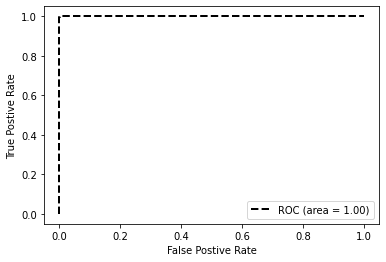

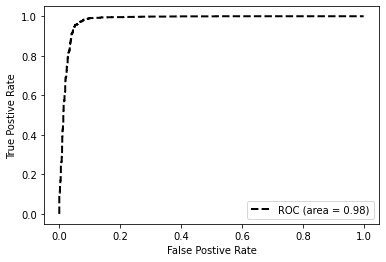

In [18]:
def plot(arr, auc, name):
    fpr, tpr = arr[0], arr[1]
    plt.plot(fpr, tpr, "k--", label='ROC (area = {0:.2f})'.format(auc), lw=2)
    plt.xlabel("False Postive Rate")
    plt.ylabel("True Postive Rate")
    plt.legend(loc="lower right")
    plt.savefig(name)
    plt.show()
    plt.close()

plot(train_fpr_tpr_thersholds[9], train_auc[9], "train_roc.pdf")
plot(test_fpr_tpr_thersholds[9], test_auc[9], "test_roc.pdf")

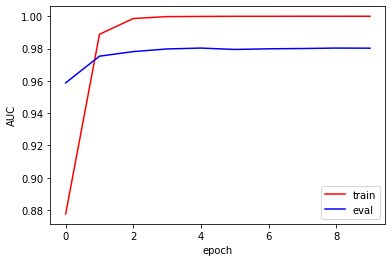

In [19]:
def plot_auc(train, test, name):
    plt.plot(range(epoch + 1), train, color="red", label="train")
    plt.plot(range(epoch + 1), test, color="blue", label="eval")
    plt.xlabel("epoch")
    plt.ylabel("AUC")
    plt.legend(loc="lower right")
    plt.savefig(name)
    plt.show()
    plt.close()
    
plot_auc(train_auc, test_auc, "auc.pdf")

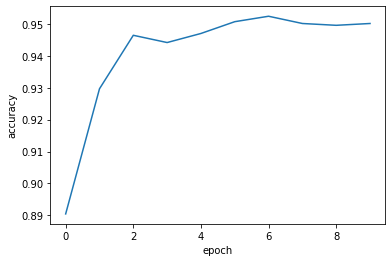

In [20]:
def plot_acc(arr, name):
    plt.plot(range(epoch + 1), arr)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.savefig(name)
    plt.show()
    plt.close()

plot_acc(test_acc, "test_acc.pdf")

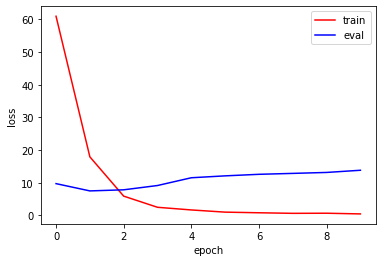

In [21]:
def plot_loss(train, test, name):
    plt.plot(range(epoch + 1), train, color="red", label="train")
    plt.plot(range(epoch + 1), test, color="blue", label="eval")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.savefig(name)
    plt.show()
    plt.close()

plot_loss(train_loss, test_loss, "loss.pdf")